In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(r"C:\Users\TCSPC\Documents\GitHub\pyTCSPC")

import pyTCSPC as pc

import multipletau as mt

from copy import deepcopy
from glob import glob
from pathlib import Path, PurePath

import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage as ndi
from scipy.optimize import curve_fit, least_squares

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu, gaussian

from tqdm.notebook import tqdm, trange

import xarray as xr

C:\Users\TCSPC\Documents\GitHub\pyTCSPC\pyTCSPC\spc.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [26]:
%cd "C:\Users\TCSPC\Desktop\2022-08-23 -- FCS -- yEA93\run2"

C:\Users\TCSPC\Desktop\2022-08-23 -- FCS -- yEA93\run2


# hit the bulk of the mito network

415


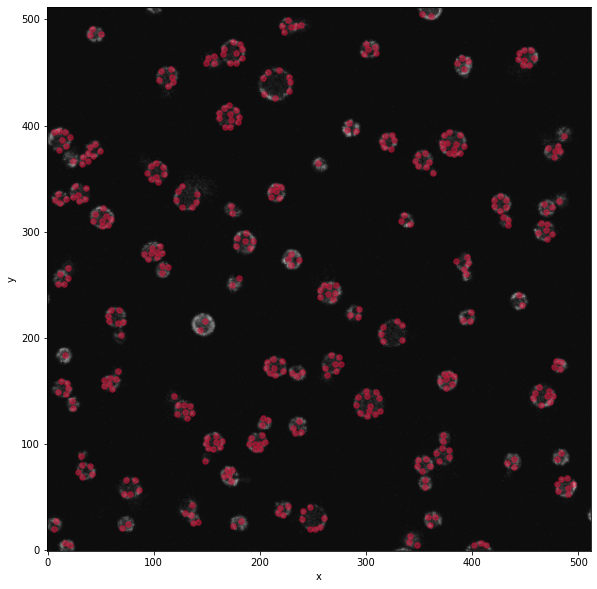

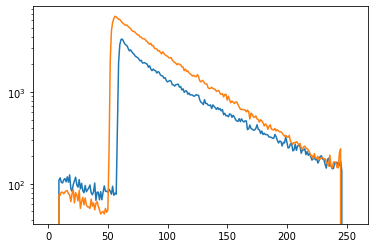

In [13]:
sdt = pc.load_sdt("img.sdt").isel(file_info=0).sel(channel="M1")

zoom = 4
nx = len(sdt.x)
ny = len(sdt.y)

im = pc.intensity_image(sdt.compute())
# im.data = np.flip(im.data, axis=0)
# plt.figure(figsize=(10,10))
# plt.imshow(im, alpha=0.5, cmap="Reds")
im = im.data
im = gaussian(im, sigma=0.5)

im_binary = im > threshold_otsu(im)
im_binary = remove_small_objects(im_binary, 6)
distance = ndi.distance_transform_edt(im_binary)
coords = peak_local_max(distance, footprint=np.ones((5, 5)), min_distance=5)
y, x = tuple(coords[:].T)

sx = ((x-(nx//2))/(nx//2))*(100/zoom)
sy = ((y-(ny//2))/(ny//2))*(100/zoom)
np.savetxt("points.dat", np.vstack([sx, sy]).T, fmt='%2.4f')

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im, cmap="gray", alpha=0.95)
plt.gca().invert_yaxis()

plt.scatter(x, y, s=30, c="crimson", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")

plt.figure()
# plt.plot(pc.decay_curve(sdt).compute())
dc1 = pc.decay_curve(pc.load_sdt("img.sdt").isel(file_info=0).sel(channel="M1").compute())
dc2 = pc.decay_curve(pc.load_sdt("img.sdt").isel(file_info=0).sel(channel="M2").compute())
plt.plot(dc1)
plt.plot(dc2)
plt.yscale("log")

print(len(coords))

# hit the edge of the mito network

In [30]:
%cd "C:\Users\TCSPC\Desktop\2022-08-23 -- FCS -- yEA93\run4"

C:\Users\TCSPC\Desktop\2022-08-23 -- FCS -- yEA93\run4


684


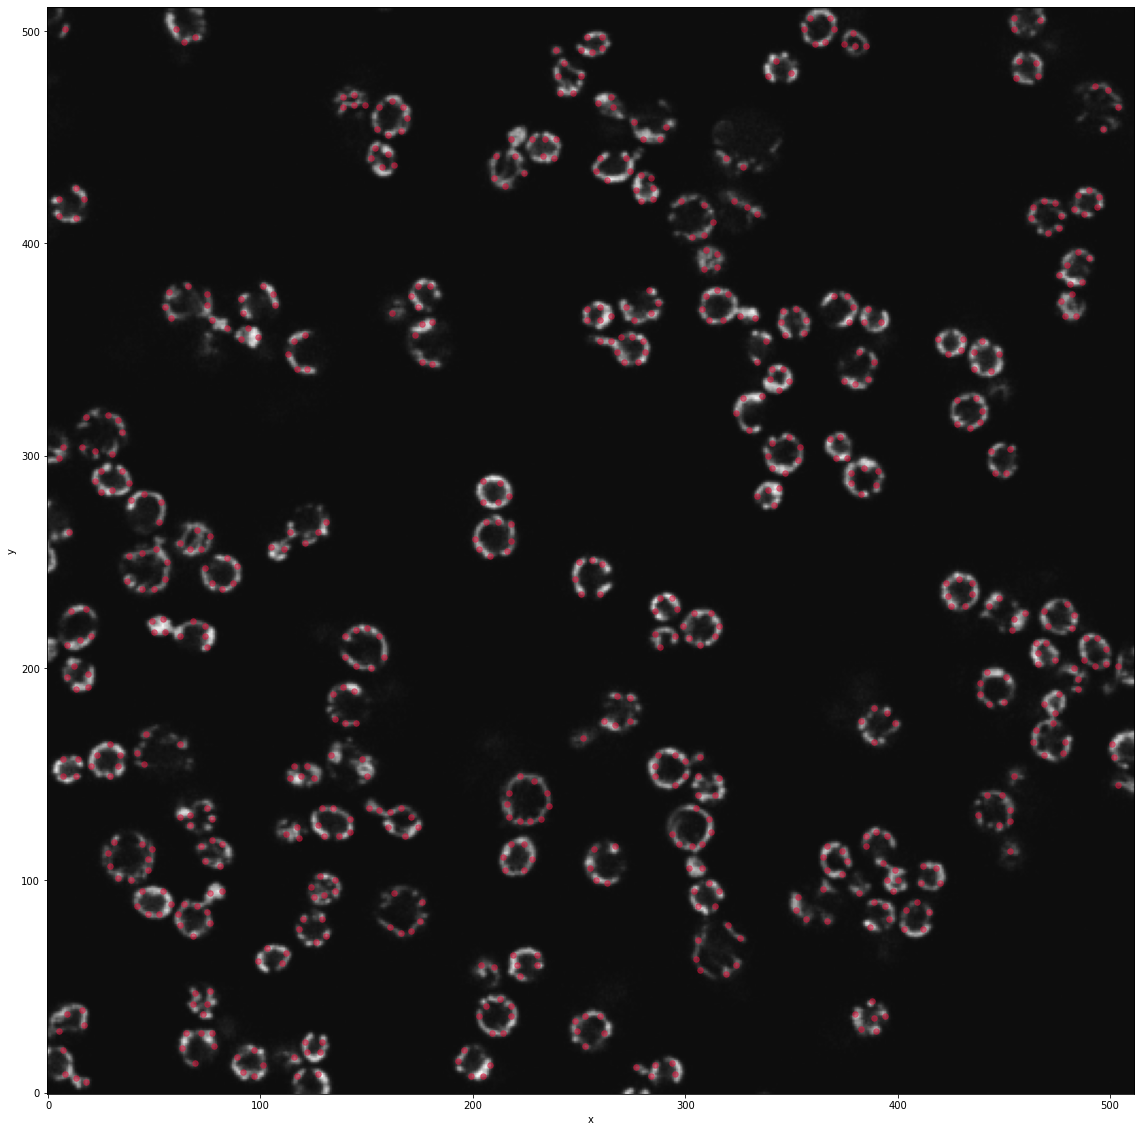

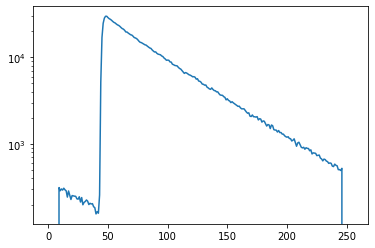

In [33]:
sdt = pc.load_sdt("img.sdt").isel(file_info=0).sel(channel="M1")

zoom = 4
nx = len(sdt.x)
ny = len(sdt.y)

im = pc.intensity_image(sdt.compute())
# im.data = np.flip(im.data, axis=0)
# plt.figure(figsize=(10,10))
# plt.imshow(im, alpha=0.5, cmap="Reds")
im = im.data
im = gaussian(im, sigma=0.5)

im_binary = im > threshold_otsu(im)
im_binary = remove_small_objects(im_binary, 6)
distance = ndi.distance_transform_edt(im_binary)

target_distance = 1.5
map_zero_to_dist = -2

adj_distance = deepcopy(distance)
is_zero = adj_distance==0
adj_distance[is_zero] = map_zero_to_dist
adj_distance = -np.square(adj_distance-target_distance)
adj_distance = adj_distance - np.min(adj_distance)
adj_distance[is_zero] = 0

coords = peak_local_max(adj_distance, footprint=np.ones((5, 5)), min_distance=5)
y, x = tuple(coords[:].T)

sx = ((x-(nx//2))/(nx//2))*(100/zoom)
sy = ((y-(ny//2))/(ny//2))*(100/zoom)
# np.savetxt("points.dat", np.vstack([sx, sy]).T, fmt='%2.4f')

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(im, cmap="gray", alpha=0.95)
# plt.imshow(distance)
plt.gca().invert_yaxis()

plt.scatter(x, y, s=30, c="crimson", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")

plt.figure()
plt.plot(pc.decay_curve(sdt).compute())
plt.yscale("log")

print(len(coords))

  0%|          | 0/38 [00:00<?, ?it/s]

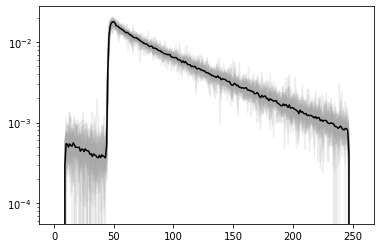

In [81]:
fns = glob("*.spc")[:]

adc = 16
maxtime = 3

bin_centers = np.arange(4096/adc)
bins = np.arange(1+4096/adc)-0.5
combined_hist = np.zeros_like(bin_centers)

i = 0
for fn in tqdm(fns):
    # if not Path(fn).with_suffix(".nc").exists():
    spc = pc.SPC(fn, pixels_per_line=1, nlines=1, n_lines_skip=0, read_paired_sdt=False, show_progress=False, save_images=False)

    hist, _ = np.histogram(spc.all_photons["microtime"].data/adc, bins=bins);
    # hist, _ = np.histogram(spc.all_photons.sel(time=slice(0, maxtime))["microtime"].data/adc, bins=bins);
    combined_hist += hist

    plt.plot(bin_centers, hist/np.sum(hist), color="darkgray", alpha=0.2)

        # i += 1
    # if i > 10:
    #     break
    
plt.plot(bin_centers, combined_hist/np.sum(combined_hist), color="k", alpha=1)
plt.yscale("log")

  0%|          | 0/30 [00:00<?, ?it/s]

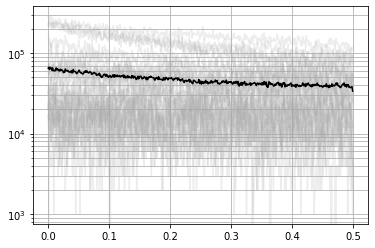

In [83]:
fns = glob("*.spc")[:30]

adc = 16
maxtime = 0.5

dt = 0.001
bins = np.arange(0,maxtime+dt,dt)
bin_centers = bins[:-1] + dt/2
combined_hist = np.zeros_like(bin_centers)

i = 0
for fn in tqdm(fns):
    # if not Path(fn).with_suffix(".nc").exists():
    spc = pc.SPC(fn, pixels_per_line=1, nlines=1, n_lines_skip=0, read_paired_sdt=False, show_progress=False, save_images=False)

    hist, _ = np.histogram(spc.all_photons["time"].data, bins=bins);
    combined_hist += hist

    plt.plot(bin_centers, hist/dt, color="darkgray", alpha=0.2)

plt.plot(bin_centers, combined_hist/len(fns)/dt, color="k", alpha=1)
plt.yscale("log")
plt.grid(which="both")

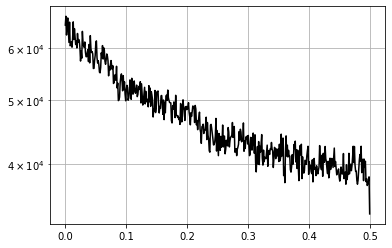

In [89]:
plt.plot(bin_centers, combined_hist/len(fns)/dt, color="k", alpha=1)
# plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")

# calculate correlation functions

  0%|          | 0/164 [00:00<?, ?it/s]

KeyError: 0.0

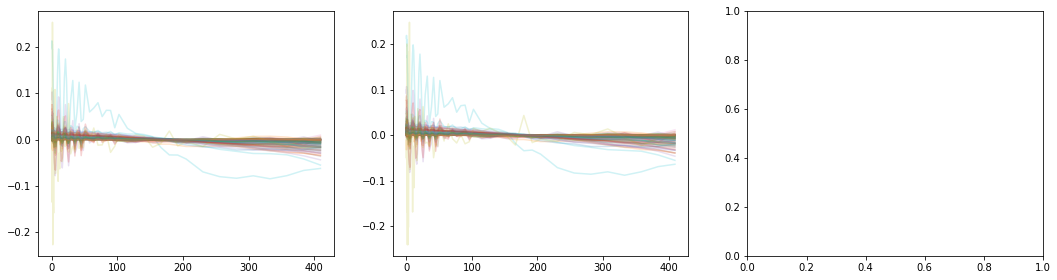

In [7]:
maxtime = 0.5
tunit = 1e3 # time unit, relative to seconds (e.g. 1e3 --> 1e-3 sec = 1 msec)
dt = 10e-5 * tunit
norm_behv = True

fig, ax = plt.subplots(figsize=(18,4.5), ncols=3)

avg_sumtau_acf = None
avg_int_acf = None

for i in tqdm(np.arange(0,len(fns))):

    for j in [0]: #range(3):
        all_photons = xr.load_dataset(
            Path(fns[i]).with_suffix(".nc")
        ).sel(time=slice(j*maxtime, (j+1)*maxtime))

        # macrotimes, now in msec
        times = tunit * all_photons["time"].data
        bin_edges = np.arange(np.min(times),np.max(times),dt)

        counts, bin_edges = np.histogram(times, bins=bin_edges, weights=all_photons["microtime"])
        lag_time, sumtau_acf = tuple(mt.autocorrelate(counts.astype(float), normalize=norm_behv, deltat=dt).T)
        if avg_sumtau_acf is None: avg_sumtau_acf  = sumtau_acf
        else:                      avg_sumtau_acf += sumtau_acf

        counts, bin_edges = np.histogram(times, bins=bin_edges)
        lag_time, int_acf = tuple(mt.autocorrelate(counts.astype(float), normalize=norm_behv, deltat=dt).T)
        if avg_int_acf is None: avg_int_acf  = int_acf
        else:                   avg_int_acf += int_acf

        ax[0].plot(lag_time[1:], int_acf[1:], alpha=0.2)
        ax[1].plot(lag_time[1:], sumtau_acf[1:], alpha=0.2)
    
mean_racf = avg_sumtau_acf/avg_int_acf

(array([0.21210476, 0.00157291]),
 array([[1.28741261e-03, 3.72795039e-05],
        [3.72795039e-05, 3.79918128e-06]]),
 635.7629691917994)

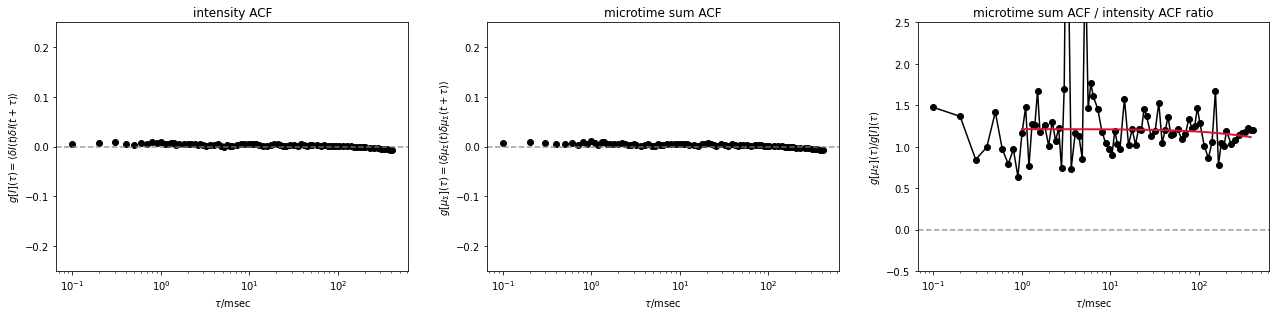

In [15]:
fig, ax = plt.subplots(figsize=(18,4.5), ncols=3)

istartlag, iendlag = 1, None
ax[0].plot(lag_time[istartlag:iendlag], avg_int_acf[istartlag:iendlag]/len(fns), "o", color="k")
ax[1].plot(lag_time[istartlag:iendlag], avg_sumtau_acf[istartlag:iendlag]/len(fns), "o", color="k")
ax[2].plot(lag_time[istartlag:iendlag], mean_racf[istartlag:iendlag], "-o", color="k")
    

for i in [0,1,2]:
    ax[i].axhline(y=0, color="gray", alpha=0.8, linestyle="--")
    ax[i].set_xlabel(r"$\tau$/msec")
    ax[i].set_xscale("log")
ax[0].set_ylabel(r"$g\left[ I \right] (\tau) = \langle \delta I(t) \delta I (t+\tau) \rangle$")
ax[1].set_ylabel(r"$g\left[ \mu_{\Sigma} \right] (\tau) = \langle \delta \mu_{\Sigma} (t) \delta \mu_{\Sigma} (t+\tau) \rangle$")
ax[2].set_ylabel(r"$g\left[ \mu_{\Sigma} \right] (\tau) / g \left[ I \right] (\tau)$")
ax[0].set_title(r"intensity ACF")
ax[1].set_title(r"microtime sum ACF")
ax[2].set_title(r"microtime sum ACF / intensity ACF ratio")
plt.tight_layout()

istartlag, iendlag = 10, -1

use = np.argwhere(np.logical_and(
    mean_racf[istartlag:iendlag] > 0,
    mean_racf[istartlag:iendlag] < 3,
)).flatten()

def func(x, a, c, ):
    return a*np.exp(-c*x) + 1
popt, pcov = curve_fit(func, lag_time[istartlag:iendlag][use], mean_racf[istartlag:iendlag][use], p0=(0.25, 1/3e0, ), bounds=([0,0,],[np.inf,np.inf,]))
yy = func(lag_time, *popt)

# def G(t, a, tau):
#     return a*np.exp(-t/tau) + 1
# def func(x0):
#     a, tau = tuple(x0)
#     t = lag_time[istartlag:iendlag]
#     y = mean_racf[istartlag:iendlag]
#     yhat = G(t, a, tau)
    
#     res = y - yhat
    
#     return res*(y**2 < 10)
    
# optresult = least_squares(func, x0=[0.25, 1/3e0,])
# yy = G(lag_time, *(optresult.x))

ax[2].plot(lag_time[istartlag:iendlag][use], yy[istartlag:iendlag][use], color="crimson", lw=2)
for i in range(2):
    ax[i].set_ylim([-0.25,0.25])
ax[2].set_ylim([-0.5,2.5])
# ax[2].set_ylim([-5,10])
# plt.savefig(f"cell{cellnum:d}.png", dpi=300, bbox_inches="tight")
popt, pcov, popt[1]**-1

In [27]:
plt.plot(func(optresult.x))

TypeError: func() missing 2 required positional arguments: 'a' and 'c'

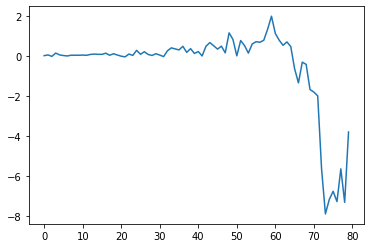

In [31]:
plt.plot((avg_int_acf[1:])*(lag_time[1:] - lag_time[:-1]))

# FLIM

### load irf

<xarray.DataArray (file_info: 1, channel: 2, x: 1, microtime_ns: 4096)>
array([[[[0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0]]]], dtype=uint32)
Coordinates:
    filename          (file_info) <U7 'IRF.sdt'
    parent_directory  (file_info) <U78 'C:\\Users\\TCSPC\\Desktop\\2022-08-02...
    acqtime           (file_info) datetime64[ns] 2022-08-02T09:20:44
    numscans          (file_info) int32 1
    laser_period      (file_info) float64 12.49
  * channel           (channel) <U2 'M1' 'M2'
  * microtime_ns      (microtime_ns) float64 0.0 0.002927 ... 11.98 11.99
Dimensions without coordinates: file_info, x

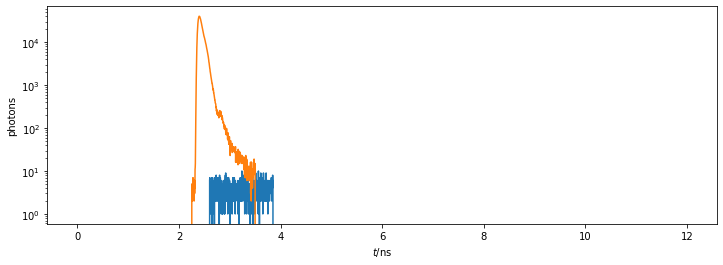

In [17]:
irf = pc.load_sdt(r"C:\Users\TCSPC\Desktop\2022-08-02 -- FLIM -- screen yEA93 +- ReAsH\calibration/IRF.sdt", dims="CXM", dtype=np.uint32).compute()
fig, ax = plt.subplots(figsize=(12,4))
dc_kwargs_M1 = {
    "trunc": True,
    "peak_start": 2.6,
    "peak_end": 3.85,
    # "bgsub": True,
    "bg_start": 8,
    "bg_end": 10,
    "fig": fig,
    "ax": ax
}
dc_kwargs_M2 = {
    "trunc": True,
    "peak_start": 2.25,
    "peak_end": 3.5,
    # "bgsub": True,
    "bg_start": 8,
    "bg_end": 10,
    "fig": fig,
    "ax": ax
}
fig, ax, dc = pc.decay_curve(irf.sel(channel="M1"), plot=True, **dc_kwargs_M1)
fig, ax, dc = pc.decay_curve(irf.sel(channel="M2"), plot=True, **dc_kwargs_M2)
plt.yscale("log")

irf

### fit

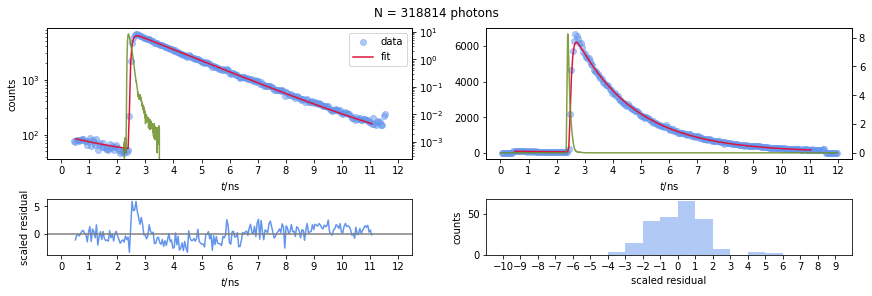

,value,err,min,max,step
shift,19.903340,0.463628,-100.0,100.0,1.000
A,0.994844,0.001218,0.7,1.0,0.001
tau1,2.111248,0.015777,2.0,5.0,0.001


In [22]:
dg = pc.decay_group(
    dc2,
    irf.sel(channel="M2"),
    irf_kws=dc_kwargs_M2,
    fit_start_bin=10,
    fit_end_bin=235
)
fitp, status = dg.fit(
    model="1exp",
    fixed_parameters=[],
    save_leastsq_params_array=True,
    verbose=False,
    plot=True
)
fitp

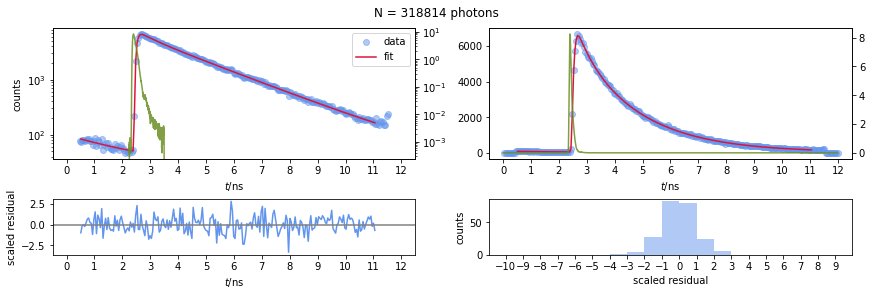

,value,err,min,max,step
shift,20.674860,0.266750,-200.00,200.0,1.000
A,0.996660,0.000798,0.70,1.0,0.001
tau1,2.229747,0.024709,1.00,9.0,0.001
tau2,0.494425,0.047003,0.01,1.0,0.001
f,0.835051,0.009673,0.01,1.0,0.001


In [23]:
fitp, status = dg.fit(
    model="2exp",
    fixed_parameters=[],
    save_leastsq_params_array=True,
    verbose=False,
    plot=True
)
fitp